In this notebook I compute the frequency of which pixels exceed certain precipitation intensity threshold. This could be an indication 

In [1]:
from os import listdir
from os.path import isfile, join
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm import tqdm

import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap


import netCDF4

from pyproj import Proj, transform
from mpl_toolkits.basemap import Basemap

In [2]:
radar_dir = '/nobackup_1/users/schreurs/project_GAN/dataset_radar_np/'
files = sorted([f for f in listdir(radar_dir) if isfile(join(radar_dir, f)) and f.startswith('2019')])
print(len(files))

103853


In [151]:
# Threshold values in 0.01mm
# 0.3mm, 3mm, 30mm, 100mm (50dBZ) heavy rain/small hail, 200mm (~60dBZ) extreme hail
thresholds = [30, 300, 3000, 10000, 20000] 

In [163]:
count_exceed = np.zeros((len(thresholds), 765,700))
count_sum = 0
error_count=0
max_val = 0
for f in tqdm(files):
    try:
        rdr = np.load(radar_dir+f)
        rdr[rdr == 65535] = 0
        if np.sum(rdr == 65535) > 0:
            print(f)
        if rdr[0][0] != 0:
            print(rdr[0][0])
    except:
        error_count=+1
        rdr = np.zeros((765,700))
        
    for i, thresh in enumerate(thresholds):
        count_exceed[i] += rdr>thresh
    if np.max(rdr) > max_val:
        max_val=np.max(rdr)
    count_sum += 1


100%|██████████| 103853/103853 [1:52:44<00:00, 15.35it/s] 


In [196]:
print('Errors: ', error_count)
print(max_val)
print(count_sum)

Errors:  1
52254
103853


In [164]:
np.save('rtcor_clutter.npy', count_exceed)

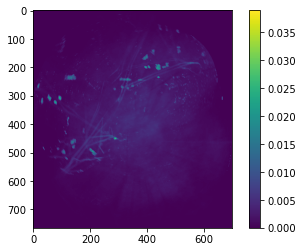

In [197]:
cmap = cm.viridis
plt.imshow(count_exceed[0]/count_sum, cmap='viridis', vmin=-0.000000001)
plt.colorbar()

In [169]:
def plot_on_map(rdr, ftype='.nc', res='l'):
    '''
    Plot radar file on top of map.
    rdr: image file
    res: resolution, can be c (crude), l (low), i (intermediate), h (high), f (full) 
    '''
    
    dir_aart = '/nobackup_1/users/schreurs/project_GAN/dataset_aart/'
    aart_fbase = 'RAD_NL25_RAC_MFBS_EM_5min_'
    
    proj = Proj("+proj=stere +lat_0=90 +lon_0=0.0 +lat_ts=60.0 +a=6378.137 +b=6356.752 +x_0=0 +y_0=0")
    
    # All images are plotted on the same map
    # Get the map from random nc file
    path = dir_aart + aart_fbase + '201901010000.nc'
    with netCDF4.Dataset(path, 'r') as ds:
        # Get coordinates of the pixels
        xx, yy = np.meshgrid(ds['x'][:], ds['y'][:])
        lon, lat = proj(xx, yy, inverse=True)
        # Plot values on map
        iso_dict = ds['iso_dataset'].__dict__
        min_x = float(iso_dict['min_x'].replace('f', ''))
        min_y = float(iso_dict['min_y'].replace('f', ''))
        max_x = float(iso_dict['max_x'].replace('f', ''))
        max_y = float(iso_dict['max_y'].replace('f', ''))
        
        if ftype == '.nc':
            rain = ds['image1_image_data'][:]
            mask = rain.mask
    
    if  ftype == '.h5':
        dir_rtcor = '/nobackup_1/users/schreurs/project_GAN/dataset_radar/'
        rtcor_fbase = 'RAD_NL25_RAC_RT_'
        path = dir_rtcor + rtcor_fbase + '201901010000.h5'
        with h5py.File(path, 'r') as f:
                rain = f['image1']['image_data'][:]
                mask = (rain == 65535)

    
    # Mask the data
    mx = np.ma.masked_array(rdr, mask)
    # Plot the precipitation on map  
    mp = Basemap(projection='stere',
                         lat_0=90,
                         lon_0=0, 
                         lat_ts=60,   
                         llcrnrlon=min_x,   # lower longitude
                         llcrnrlat=min_y,    # lower latitude
                         urcrnrlon=max_x,   # uppper longitude
                         urcrnrlat=max_y,   # uppper latitude
                         resolution=res
                        )
    mp.drawcoastlines()
    mp.drawstates()
    mp.drawcountries()

    xx, yy = mp(lon, lat)

    vmin=-0.00001    
    cmap = cm.viridis
    plt.imshow(mx, vmin = vmin, cmap=cmap, origin='upper', 
           extent=[xx.min(), xx.max(), yy.min(), yy.max()])
    plt.colorbar()

<ipython-input-169-4ce9354d1def>:21: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  iso_dict = ds['iso_dataset'].__dict__


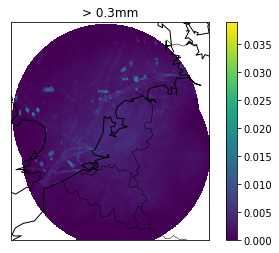

In [198]:
i=0
plot_on_map(count_exceed[i]/count_sum, ftype='.h5')
plt.title('> {}mm'.format(thresholds[i]/100))
plt.savefig('figures/freq_above_03mm')

<ipython-input-169-4ce9354d1def>:21: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  iso_dict = ds['iso_dataset'].__dict__


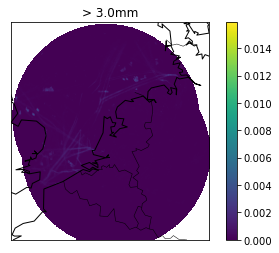

In [199]:
i=1
plot_on_map(count_exceed[i]/count_sum, ftype='.h5')
plt.title('> {}mm'.format(thresholds[i]/100))
plt.savefig('figures/freq_above_3mm')

<ipython-input-169-4ce9354d1def>:21: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  iso_dict = ds['iso_dataset'].__dict__


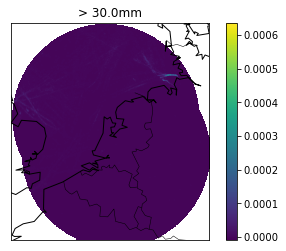

In [200]:
i=2
plot_on_map(count_exceed[i]/count_sum, ftype='.h5')
plt.title('> {}mm'.format(thresholds[i]/100))
plt.savefig('figures/freq_above_30mm')

<ipython-input-169-4ce9354d1def>:21: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  iso_dict = ds['iso_dataset'].__dict__


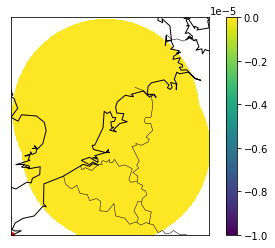

In [201]:
i=3
plot_on_map(count_exceed[i], ftype='.h5')
plt.scatter(19,438,color='r')


In [202]:
np.unique(count_exceed[i])

array([0., 1.])

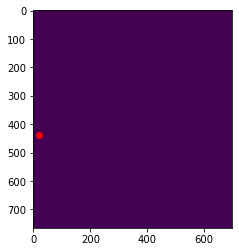

In [203]:
plt.imshow(count_exceed[3], vmin=-0.00001)
plt.scatter(19,438,color='r')

In [186]:
ind = np.argmax(count_exceed[i])
np.unravel_index(ind, (765,700))

(19, 438)